In [17]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import lines
from astropy.io import fits
from astropy import stats
from astropy.table import Table


In [4]:
# CCD, Raft, Focal plane helpers
from exploreRaft import exploreRaft
def getccdid(raft,run=None):
    ccdid = {}
    eR = exploreRaft(db='Prod')
    ccd_list = eR.raftContents(raftName=raft,run=run)
    for araft in ccd_list:
        ccdid[araft[1]] = araft[0]
    return ccdid

def getrafttype(raft):
    ccdid = {}
    eR = exploreRaft(db='Prod')
    raft_type = eR.raft_type(raft=raft)
    return raft_type

# Get segment names and index by Amp number. ordering corresponds to counting from Amp# from 1 to 16
segmentName = {}
ampNumber = {}
#top
for iAmp in range(1,8+1):
    segmentName[iAmp] = "1%d" % (iAmp - 1)
    ampNumber[segmentName[iAmp]] = iAmp
#bottom
for iAmp in range(9,16+1):
    segmentName[iAmp] = "0%d" % (16 - iAmp)
    ampNumber[segmentName[iAmp]] = iAmp

print("SegmentName keyed by Amp#",segmentName)
print("Amp# keyed by SegmentName",ampNumber)



SegmentName keyed by Amp# {1: '10', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '17', 9: '07', 10: '06', 11: '05', 12: '04', 13: '03', 14: '02', 15: '01', 16: '00'}
Amp# keyed by SegmentName {'10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '07': 9, '06': 10, '05': 11, '04': 12, '03': 13, '02': 14, '01': 15, '00': 16}


In [5]:
def getEOInfo(rtmid='RTM-009',run=11415,disk='fs3'):

    # Specify a raft and a run to analyze.
    root_dir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-11021_RTM' % (disk)
    raft = 'LCA-11021_%s' % (rtmid)
    run = str(run) 

    # A function to help gather the data.
    def glob_files(*args):
        apath = os.path.join(root_dir, raft, run, *args)
        #print(apath)
        return sorted(glob.glob(apath))
        
    # get CCDs by slot.
    ccdid = getccdid(raft)

    # For linearity and ptc tasks.
    raft_results = {}
    for aslot in ccdid:
        raft_results[aslot] = glob_files('collect_raft_results', 'v0', '*','%s_eotest_results.fits' % (ccdid[aslot]))
    
    # put results into one big DataFrame
    dfList = []
    for aslot in ccdid:
        hdu = fits.open(raft_results[aslot][0])
        table = Table(hdu[1].data)
        df = table.to_pandas()
        
        # add to DF with more info
        df['SLOT'] = aslot
        df['CCDID'] = ccdid[aslot]
        
        dfList.append(df)
        
    # combine DFs 
    dfAll = pd.concat(dfList, ignore_index=True)

    return dfAll,ccdid



In [6]:
def getBOTEOInfo(run="11415",disk='fs3'):

    # Specify a raft and a run to analyze.
    if run[-1:]=='D':
        root_dir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/' % (disk)
    else:
        root_dir = '/gpfs/slac/lsst/%s/g/data/jobHarness/jh_archive/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/' % (disk)
    run = str(run) 

    # A function to help gather the data.
    def glob_files(*args):
        apath = os.path.join(root_dir, run, *args)
        #print(apath)
        return sorted(glob.glob(apath))

    # Get all result files
    all_results = glob_files('raft_results_summary_BOT', 'v0', '*','*_eotest_results.fits')
    #print(all_results)
    
    # identify which files correspond to which rafts/slots
    crtms = ['R00','R04','R40','R44']
    rtms = ['R01','R02','R10','R11','R12','R20','R21','R22','R30']
    
    cslots = ['SG0','SG1','SW1','SW2']
    slots = ['S00','S01','S02','S10','S11','S12','S20','S21','S22']
    
    bayslots = []
    results = {}
    for abay in rtms:
        for aslot in slots:
            bayslot = '%s_%s' % (abay,aslot)
            bayslots.append(bayslot)
                
    for abay in crtms:
        for aslot in cslots:
            bayslot = '%s_%s' % (abay,aslot)
            bayslots.append(bayslot)
            
    #print(bayslots)
            
    for aresult in all_results:
        for bayslot in bayslots:
            if bayslot in aresult:
                results[bayslot] = aresult

    #print(results)
    # put results into one big DataFrame
    dfList = []
    for bayslot in bayslots:
        if bayslot in results.keys():
            hdu = fits.open(results[bayslot])
            table = Table(hdu[1].data)
            df = table.to_pandas()
        
            # add to DF with more info
            df['BAYSLOT'] = bayslot
            df['BAY'] = bayslot[0:3]
            df['SLOT'] = bayslot[4:]
            #df['CCDID'] = ccdid[aslot]
        
            dfList.append(df)
        
    # combine DFs 
    dfAll = pd.concat(dfList, ignore_index=True,sort=False)

    return dfAll



In [7]:
dfAll = getBOTEOInfo(run="6908D")
#dfAll_gains =  getBOTEOInfo(run="6774D")

In [8]:
#print(dfAll_gains[['GAIN','BAY']])

In [9]:
print(dfAll[['AMP','BAYSLOT','BAY','SLOT']])
print(dfAll.columns)

      AMP  BAYSLOT  BAY SLOT
0       1  R01_S00  R01  S00
1       2  R01_S00  R01  S00
2       3  R01_S00  R01  S00
3       4  R01_S00  R01  S00
4       5  R01_S00  R01  S00
5       6  R01_S00  R01  S00
6       7  R01_S00  R01  S00
7       8  R01_S00  R01  S00
8       9  R01_S00  R01  S00
9      10  R01_S00  R01  S00
10     11  R01_S00  R01  S00
11     12  R01_S00  R01  S00
12     13  R01_S00  R01  S00
13     14  R01_S00  R01  S00
14     15  R01_S00  R01  S00
15     16  R01_S00  R01  S00
16      1  R01_S01  R01  S01
17      2  R01_S01  R01  S01
18      3  R01_S01  R01  S01
19      4  R01_S01  R01  S01
20      5  R01_S01  R01  S01
21      6  R01_S01  R01  S01
22      7  R01_S01  R01  S01
23      8  R01_S01  R01  S01
24      9  R01_S01  R01  S01
25     10  R01_S01  R01  S01
26     11  R01_S01  R01  S01
27     12  R01_S01  R01  S01
28     13  R01_S01  R01  S01
29     14  R01_S01  R01  S01
...   ...      ...  ...  ...
1410    3  R44_SG1  R44  SG1
1411    4  R44_SG1  R44  SG1
1412    5  R44

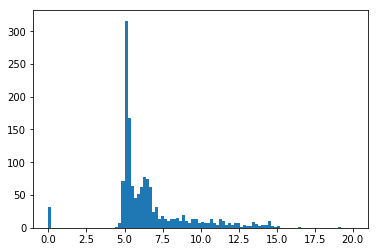

In [10]:
f,ax = plt.subplots(1,1)
h = ax.hist(dfAll['READ_NOISE'],bins=100,range=(0,20))

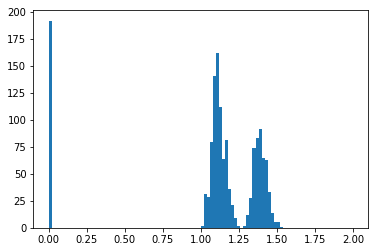

In [11]:
f,ax = plt.subplots(1,1)
h = ax.hist(dfAll['GAIN'],bins=100,range=(0,2))

In [12]:
# print bad values
print(dfAll[dfAll.READ_NOISE<4.][['AMP','READ_NOISE','BAYSLOT']])

      AMP  READ_NOISE  BAYSLOT
1288    9         0.0  R00_SW1
1289   10         0.0  R00_SW1
1290   11         0.0  R00_SW1
1291   12         0.0  R00_SW1
1292   13         0.0  R00_SW1
1293   14         0.0  R00_SW1
1294   15         0.0  R00_SW1
1295   16         0.0  R00_SW1
1336    9         0.0  R04_SW1
1337   10         0.0  R04_SW1
1338   11         0.0  R04_SW1
1339   12         0.0  R04_SW1
1340   13         0.0  R04_SW1
1341   14         0.0  R04_SW1
1342   15         0.0  R04_SW1
1343   16         0.0  R04_SW1
1384    9         0.0  R40_SW1
1385   10         0.0  R40_SW1
1386   11         0.0  R40_SW1
1387   12         0.0  R40_SW1
1388   13         0.0  R40_SW1
1389   14         0.0  R40_SW1
1390   15         0.0  R40_SW1
1391   16         0.0  R40_SW1
1432    9         0.0  R44_SW1
1433   10         0.0  R44_SW1
1434   11         0.0  R44_SW1
1435   12         0.0  R44_SW1
1436   13         0.0  R44_SW1
1437   14         0.0  R44_SW1
1438   15         0.0  R44_SW1
1439   1

In [13]:
print(dfAll[dfAll.READ_NOISE>20.][['AMP','READ_NOISE','BAYSLOT']])

      AMP  READ_NOISE  BAYSLOT
40      9   26.578608  R01_S02
79     16   24.208347  R01_S11
1104    1  195.519379  R30_S00
1299    4   93.053391  R04_SG0
1302    7  149.329712  R04_SG0
1303    8   67.523643  R04_SG0
1367    8  175.965042  R40_SG1
1402   11  104.917336  R44_SG0


In [14]:
print(dfAll[dfAll.BAY=='R10'][['AMP','READ_NOISE','SLOT']])

     AMP  READ_NOISE SLOT
288    1   11.803357  S10
289    2   11.281214  S10
290    3   11.058372  S10
291    4   11.104874  S10
292    5   10.588514  S10
293    6   10.207903  S10
294    7    9.521043  S10
295    8   12.425530  S10
296    9   13.044715  S10
297   10    9.614188  S10
298   11   11.759725  S10
299   12   10.785761  S10
300   13   11.792445  S10
301   14   10.859139  S10
302   15   12.322941  S10
303   16   12.525657  S10
304    1    6.351626  S11
305    2    6.368368  S11
306    3    6.466081  S11
307    4    6.547586  S11
308    5    6.818225  S11
309    6    6.369688  S11
310    7    6.275495  S11
311    8    6.817024  S11
312    9    9.402788  S11
313   10    7.422116  S11
314   11    7.926661  S11
315   12    8.027948  S11
316   13    8.454639  S11
317   14    8.808916  S11
..   ...         ...  ...
354    3    6.073857  S21
355    4    6.139238  S21
356    5    6.101390  S21
357    6    6.010994  S21
358    7    6.038817  S21
359    8    6.048952  S21
360    9    

In [15]:
# good runs for Science Rafts
goodruns = {'RTM-004':7984,'RTM-005':11852,'RTM-006':11746,'RTM-007':4576,'RTM-008':5761,'RTM-009':11415,'RTM-010':6350,\
            'RTM-011':10861,'RTM-012':11063,'RTM-013':10982,'RTM-014':10928,'RTM-015':7653,'RTM-016':8553,'RTM-017':11166,'RTM-018':9056,'RTM-019':11808,\
            'RTM-020':10669,'RTM-021':8988,'RTM-022':11671,'RTM-023':10517,'RTM-024':11351,'RTM-025':10722}

# raft to bay assignments
rtmlocs = {'R00':'CRTM-0002','R40':'CRTM-0003','R04':'CRTM-0004','R44':'CRTM-0005','R01':'RTM-011','R11':'RTM-020','R10':'RTM-023',\
          'R20':'RTM-014','R30':'RTM-012','R21':'RTM-025','R22':'RTM-024','R12':'RTM-009','R02':'RTM-013'}



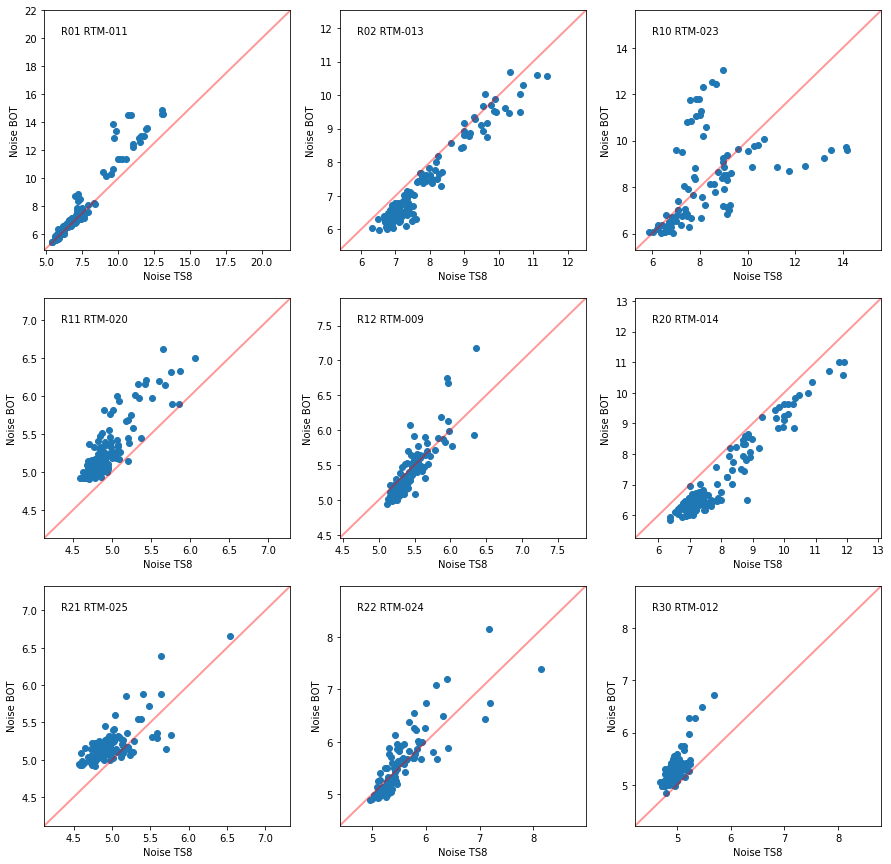

In [20]:
# loop over installed Science Raft bays, compare READ_NOISE in the BOT vs. Good Runs

rtms = ['R01','R02','R10','R11','R12','R20','R21','R22','R30']
slots = ['S00','S01','S02','S10','S11','S12','S20','S21','S22']
rtm_type = {'R01':'itl','R02':'itl','R10':'itl','R11':'e2v','R12':'e2v','R20':'itl','R21':'e2v','R22':'e2v','R30':'e2v'}

f,ax = plt.subplots(3,3,figsize=(15,15))
axf = ax.flatten()

for i,abay in enumerate(rtms):
    thertm = rtmlocs[abay]
    good_run = goodruns[thertm]
    
    df_raft,ccdid = getEOInfo(rtmid=thertm,run=good_run)
    
    # plot noise 
    noise_ts8 = df_raft['READ_NOISE']
    gain_ts8 = df_raft['GAIN']
    noise_bot = dfAll[dfAll.BAY == abay]['READ_NOISE']
    #gain_bot = dfAll_gains[dfAll_gains.BAY == abay]['GAIN']
    
    #if rtm_type[abay] == 'e2v':
    #    gain = 1.15/gain_bot
    #else:
    #    gain = 1.35/gain_bot

    if len(noise_ts8) != len(noise_bot):
        noise_ts8 = noise_ts8[48:]   # special since one REB is off on R10
    
    axf[i].scatter(noise_ts8,noise_bot)
    axf[i].text(0.07,0.9,'%s %s' % (abay,thertm),transform=axf[i].transAxes)
    axf[i].set_xlabel('Noise TS8')
    axf[i].set_ylabel('Noise BOT')
    
    # auto-range
    maxx = np.max(noise_ts8)
    maxy = np.max(noise_bot)
    if maxx>20:
        maxx = 20.
    if maxy>20:
        maxy = 20.
    minx = np.min(noise_ts8)
    miny = np.min(noise_bot)
    
    minxy = min(minx,miny)
    maxxy = max(maxx,maxy)

    if abay =='R30':
        maxxy = 8.
    
    axf[i].set_xlim(minxy*0.9,maxxy*1.1)
    axf[i].set_ylim(minxy*0.9,maxxy*1.1)
        
    line = lines.Line2D([minxy*0.9,maxxy*1.1], [minxy*0.9,maxxy*1.1], lw=2., color='r', alpha=0.4)
    axf[i].add_line(line)
    
    
    

In [25]:
print(dfAll[dfAll.BAY == 'R10'][['READ_NOISE','SLOT','AMP','GAIN']])
print(dfAll[(dfAll.BAY == 'R10') & (dfAll.SLOT=='S10')][['READ_NOISE','SLOT','AMP','GAIN']])

     READ_NOISE SLOT  AMP      GAIN
288   11.803357  S10    1  1.419277
289   11.281214  S10    2  1.402510
290   11.058372  S10    3  1.405525
291   11.104874  S10    4  1.414341
292   10.588514  S10    5  1.402717
293   10.207903  S10    6  1.395219
294    9.521043  S10    7  1.406030
295   12.425530  S10    8  1.387509
296   13.044715  S10    9  1.317055
297    9.614188  S10   10  1.369221
298   11.759725  S10   11  1.376821
299   10.785761  S10   12  1.367000
300   11.792445  S10   13  1.372233
301   10.859139  S10   14  1.375468
302   12.322941  S10   15  1.381974
303   12.525657  S10   16  1.378349
304    6.351626  S11    1  1.400098
305    6.368368  S11    2  1.397131
306    6.466081  S11    3  1.402387
307    6.547586  S11    4  1.406089
308    6.818225  S11    5  1.412327
309    6.369688  S11    6  1.402544
310    6.275495  S11    7  1.412896
311    6.817024  S11    8  1.431225
312    9.402788  S11    9  1.353193
313    7.422116  S11   10  1.406816
314    7.926661  S11   11  1

comments:

1. the channels with higher noise in R10 are in Slot S10, or perhaps S22